In [1]:
import pandas as pd
import numpy as np
import load_data
import xgboost
import shap
from datetime import date

import matplotlib.pyplot as plt
%matplotlib inline

C:\Anaconda3\lib\site-packages\sklearn\ensemble\weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [2]:
try:
    data = pd.read_csv('data_201810.csv')
except OSError:
    r = load_data.RegionTotalReport()
    data = r.download(date(2018, 10, 1), date(2018, 10, 31))
    data.to_csv('data_201810.csv', index=False)

In [3]:
data['con'] += data['vol_gen_blockstan']

In [4]:
data['gen'] = data['gen_ges'] + data['gen_aes'] + data['gen_ves'] + data['gen_ses'] + data['gen_tes'] + data['gen_other']

In [5]:
data['losses'] = (data['gen'] + data['imp']) - (data['con'] + data['exp'])

In [6]:
data['gen_per_pmax_aes'] = data['gen_aes'] / data['pmax_aes']
data['gen_per_pmax_ges'] = data['gen_ges'] / data['pmax_ges']
data['gen_per_pmax_tes'] = data['gen_tes'] / data['pmax_tes']
data['gen_per_pmax_ves'] = data['gen_ves'] / data['pmax_ves']
data['gen_per_pmax_ses'] = data['gen_ses'] / data['pmax_ses']
data['gen_per_pmax_other'] = data['gen_other'] / data['pmax_other']

In [7]:
data['gen_per_pmin_aes'] = data['gen_aes'] / data['pmin_aes']
data['gen_per_pmin_ges'] = data['gen_ges'] / data['pmin_ges']
data['gen_per_pmin_tes'] = data['gen_tes'] / data['pmin_tes']

In [8]:
data.replace([np.inf, -np.inf, np.nan], 2, inplace=True)

In [9]:
y = data.price_con
X = data.drop(['price_con', 'price_gen', 'region_id', 'date', 'hour'], axis=1)

In [10]:
model = xgboost.XGBRegressor(max_depth=7, learning_rate=0.05, n_estimators=400)
model.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=7, min_child_weight=1, missing=None, n_estimators=400,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

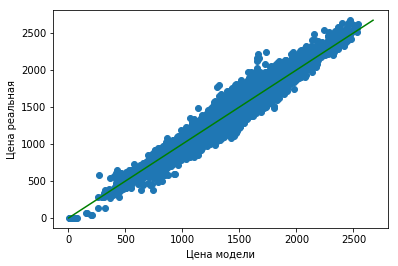

In [11]:
y_pred = model.predict(X)
plt.scatter(y_pred, y)
plt.plot([y.min(), y.max()], [y.min(), y.max()], c='g')

plt.xlabel('Цена модели')
plt.ylabel('Цена реальная')
plt.savefig('pic/tree0.png', transparent=True)

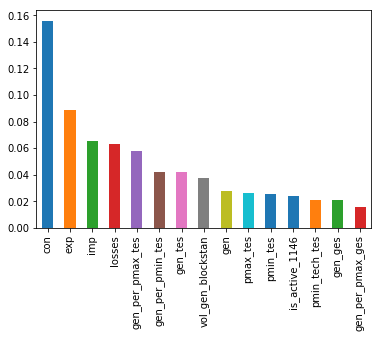

In [19]:
importance = pd.Series(model.feature_importances_, index=X.columns)
importance = importance[importance > 0].sort_values(ascending=False).head(15)
importance.plot('bar')

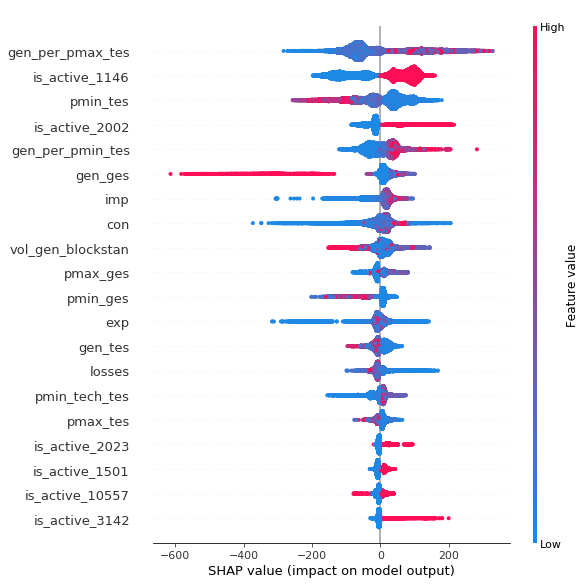

In [22]:
shap_values = shap.TreeExplainer(model).shap_values(X)
shap.summary_plot(shap_values, X)

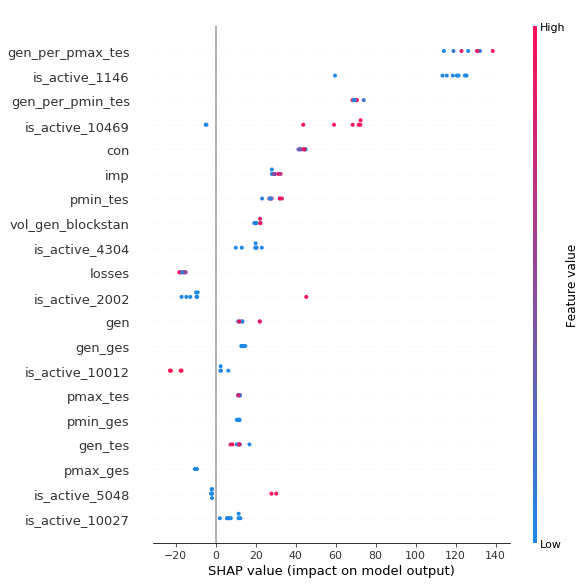

In [65]:
samples = data.loc[(data.region_id == 94) & (data.price_con > 2000), X.columns]

shap_values1 = shap.TreeExplainer(model).shap_values(samples)
shap.summary_plot(shap_values1, samples)

In [72]:
data.loc[
    (data.region_id == 94) & (data.price_con > 2000),
    ['date', 'hour', 'gen_per_pmax_tes', 'gen_per_pmin_tes', 'is_active_1146', 'is_active_10469', 'price_con']
]

,date,hour,gen_per_pmax_tes,gen_per_pmin_tes,is_active_1146,is_active_10469,price_con
597,2018-10-04,8,0.979722,1.682991,1.0,0.0,2009.70
664,2018-10-04,9,0.979719,1.683197,1.0,0.0,2015.42
731,2018-10-04,10,0.979719,1.683197,1.0,1.0,2000.50
798,2018-10-04,11,0.979722,1.682991,1.0,1.0,2000.85
865,2018-10-04,12,0.979765,1.680524,1.0,1.0,2000.40
932,2018-10-04,13,0.979758,1.680934,1.0,1.0,2000.70
1200,2018-10-04,17,0.979758,1.680934,1.0,1.0,2002.01
1267,2018-10-04,18,0.979765,1.680524,1.0,1.0,2002.03
